# Cargo Holds: Clean or Dirty
___

#### Background

Owning and operating a dry bulk vessel is challenging.  Earning a profit on any voyage is not a given even with careful calculations, knowledge, and a solid strategy.  Not only only are these profit margins getting thinner but they are absorbing more and more risk to earn them.  One of those risks is fixing a cargo that the vessel's cargo holds might not be ready for on time.  This leads to costly delays, tens of thousands of dollars in time, additional cleaning costs, and damage to a carriers reputation with a charterer.
___

#### Problem Statement

Vessel operators have to decide a vessel's next cargo well ahead of knowing the condition her holds will be in when the vessel arrives to load the cargo.  The operator may have some knowledge to this problem, such as: the vessel's cargo histroy, overall condition of her holds coatings from the time of hire, and possibly the crew's experience and capability preparing the vessel's holds.  However, the determination of the suitability of her holds is left to an inspector's review of her holds before loading that the vessel operator does not have knowledge of in advance.
___

#### Solution

That is why we have created this model.  With this deep learning CNN model, we have trained it on thousands of images of clean and dirty cargo holds against pictures of vessels that have passed inspection.  With this tool the vessel operator can quickly determine the likliehood, not a guarantee, that the vessel's holds will be accepted for the intended cargo.
___

#### Evidence

This project lays out the steps and strategy taken to produce a model of distinguishing between a clean and dirty cargo hold.  The model has been measured for accuracy with the goal of reducing false positives.  In the problem of classifying a hold as clean or dirty, clean is a positive outcome and dirty is a negative outcome.  Therefore a false positive, an instance where the model incorrectly predicts the holds are clean, are limited. 
___

#### Engage

The model is only as good as the images it is provided.  If the images provided omit trouble spots or are not providing enough detail the results will be misleading.  The tool can be tried by submitting an image to the following link.

___

In [113]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, smart_resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## Data
___

There were no publicly available datasets found online.  The dataset for this problem had to be collected.  From there it will be explored, pre-processed, and organized before being modeled.
___

![Data Directory](../assets/Data_Directory.jpg)


#### Data Collection

The data was provided by Three Ds Marine Inc.  Three Ds Marine Inc is a cargo hold cleaning company based out of the Columbia River.  They were chosen, as not only do they do great work, because they are hired to prepare vessels for some of the more challenging cargo cleanliness standards to meet.  

The Columbia River is one of the top grain exporteres in the worlds (behind the Mississippi River and Parana River).  Vessels need to be very clean in order to transport grains.  While this cleanliness standard is high, it is not the highest as some cargos need "hospital clean" cargo holds.  These cargos are extremely sensitive to contamination, such as soda ash.  The Columbia River is also one of the largest exporters of soda ash which is used in the production of glass, detergents, batteries amongst other uses.

Three D's allowed access to their website and some files that were readily available on their phones.  They are going to augment the original data once a more meaningful architecture is in place.

<u> **A stretch goal of this problem is to work with Three Ds to build out an architecure to collect, organize, label, and update the model on an ongoing basis.** <u>
___

In [2]:
# Collect list of image names
collected_path = '../data/collected'
raw_images = [i for i in os.listdir(collected_path)]
len(raw_images)

560

In [3]:
# Count of different types
image_types = []
for image in raw_images:
     image_types.append(image.split('.')[1])
image_types_count = pd.Series(image_types).value_counts()
image_types_count

jpg     520
JPEG     37
JPG       3
Name: count, dtype: int64

___
JPG files combine a good balance between quality and size for this project.  
Non jpg files will be convert to jpg files.
There are a few different methods to converting file types depending on the type.  
This dataset converted some webp files to jpgs.
___

In [4]:
# Convert webp files to jpg

def convert_webp_jpg(file_path):
    """Converting webp files to jpg.  JPG are well suited for CNNs due to size and quality""" 
    raw_dataset = os.listdir(file_path)
    for file in raw_dataset:
        if file.lower().endswith('.webp'):
            path = file_path + file
            with Image.open(path) as pic:
                pic = pic.convert('RGB')
                jpg = file.rsplit('.', 1)[0] + '.jpg'
                new_path = file_path + jpg
                pic.save(new_path, 'JPEG')

In [5]:
# convert_webp_jpg('../data/collected/')

Images were classified as dirty or clean after visual review.  To track the same, they were entered into a database, along with their clean or dirty classification, and new name.

In [6]:
# Collect list of clean cargo holds
clean_path = '../data/classified/clean/'
clean_images = [i for i in os.listdir(clean_path)]
clean_df = pd.DataFrame(clean_images, columns = ['original_name'])
clean_df['source'] = "Three D's Marine Inc."
clean_df['class'] = 0
clean_df['new_name'] = 'clean_' + clean_df.index.astype(str)
clean_df.head()

,original_name,source,class,new_name
0,100072920_2995576610489581_2211899507375865856...,Three D's Marine Inc.,0,clean_0
1,12c943_05af8b83336a4cab832984ca2ee433a9~mv2.jpg,Three D's Marine Inc.,0,clean_1
2,12c943_0d9097faf57245fb9ab06fdc683593e0~mv2.jpg,Three D's Marine Inc.,0,clean_2
3,12c943_0e95ce59ba674e72a85e742df4ef6b14~mv2.jpg,Three D's Marine Inc.,0,clean_3
4,12c943_35c4d1432c5c42828eaf570244a4c72d~mv2.jpg,Three D's Marine Inc.,0,clean_4


In [7]:
# Collect list of dirty cargo holds
dirty_path = '../data/classified/dirty/'
dirty_images = [i for i in os.listdir(dirty_path)]
dirty_df = pd.DataFrame(dirty_images, columns = ['original_name'])
dirty_df['source'] = "Three D's Marine Inc."
dirty_df['class'] = 1
dirty_df['new_name'] = 'dirty_' + dirty_df.index.astype(str)
dirty_df.head()

,original_name,source,class,new_name
0,100051832_2995576943822881_4862361595679866880...,Three D's Marine Inc.,1,dirty_0
1,100100291_2995576600489582_4072725179636121600...,Three D's Marine Inc.,1,dirty_1
2,100474906_2995576417156267_4349487993107513344...,Three D's Marine Inc.,1,dirty_2
3,100479422_2995576340489608_373633833737650176_...,Three D's Marine Inc.,1,dirty_3
4,100479425_2995580610489181_6851986478084390912...,Three D's Marine Inc.,1,dirty_4


In [8]:
# Combine into one dataframe
images_df = pd.concat([clean_df, dirty_df], ignore_index=False)
images_df

,original_name,source,class,new_name
0,100072920_2995576610489581_2211899507375865856...,Three D's Marine Inc.,0,clean_0
1,12c943_05af8b83336a4cab832984ca2ee433a9~mv2.jpg,Three D's Marine Inc.,0,clean_1
2,12c943_0d9097faf57245fb9ab06fdc683593e0~mv2.jpg,Three D's Marine Inc.,0,clean_2
3,12c943_0e95ce59ba674e72a85e742df4ef6b14~mv2.jpg,Three D's Marine Inc.,0,clean_3
4,12c943_35c4d1432c5c42828eaf570244a4c72d~mv2.jpg,Three D's Marine Inc.,0,clean_4
...,...,...,...,...
461,IMG_2456.jpg,Three D's Marine Inc.,1,dirty_461
462,IMG_2457.jpg,Three D's Marine Inc.,1,dirty_462
463,IMG_3177.jpg,Three D's Marine Inc.,1,dirty_463
464,IMG_3179.jpg,Three D's Marine Inc.,1,dirty_464


#### Data Exploration

The initial dataset contained 560 images.  It was straightforward to classify the holds as clean or dirty working with a dataset of this size.  It was also quickly noticeable that this dataset is imbalanced, with 94 clean cargo holds and 466 dirty cargo holds.  In the real world, this data should be perfectly balanced as a cargo hold is either clean or dirty for the purposes of this problem.  The working process for determining cargo hold cleanlieness would start with dirty cargo holds and end with clean holds.

From this initial classification of the dataset, the images will be explored further to get a better understanding viusally of the data, the types of issues that render a cargo hold dirty, and the distribution of the size of images.
___

In [9]:
# Size of classes in the dataset
num_clean = len([i for i in os.listdir('../data/classified/clean/')])
num_dirty = len([i for i in os.listdir('../data/classified/dirty/')])
num_clean, num_dirty

(94, 466)

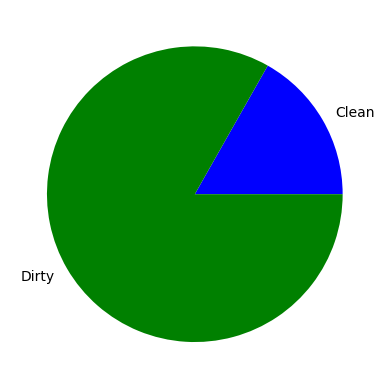

In [10]:
# Pie chart with class distribution
fig, ax = plt.subplots()
ax.pie(x=[num_clean, num_dirty], labels=['Clean', 'Dirty'], colors=['blue', 'green'])
plt.show;

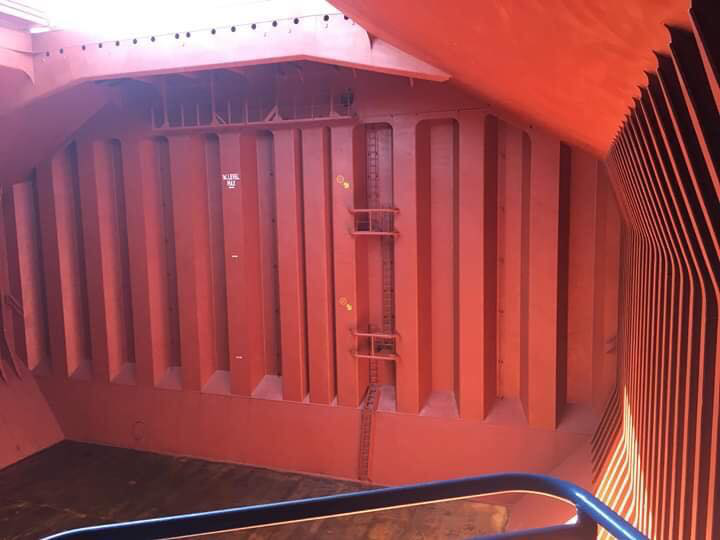

In [11]:
# Review clean cargo hold image
clean1 = load_img('../data/classified/clean/47681173_2008763662504219_1873423245131120640_n.jpg')
clean2 = load_img('../data/classified/clean/48418327_2026951410685444_6927397904709582848_n.jpg')
clean1

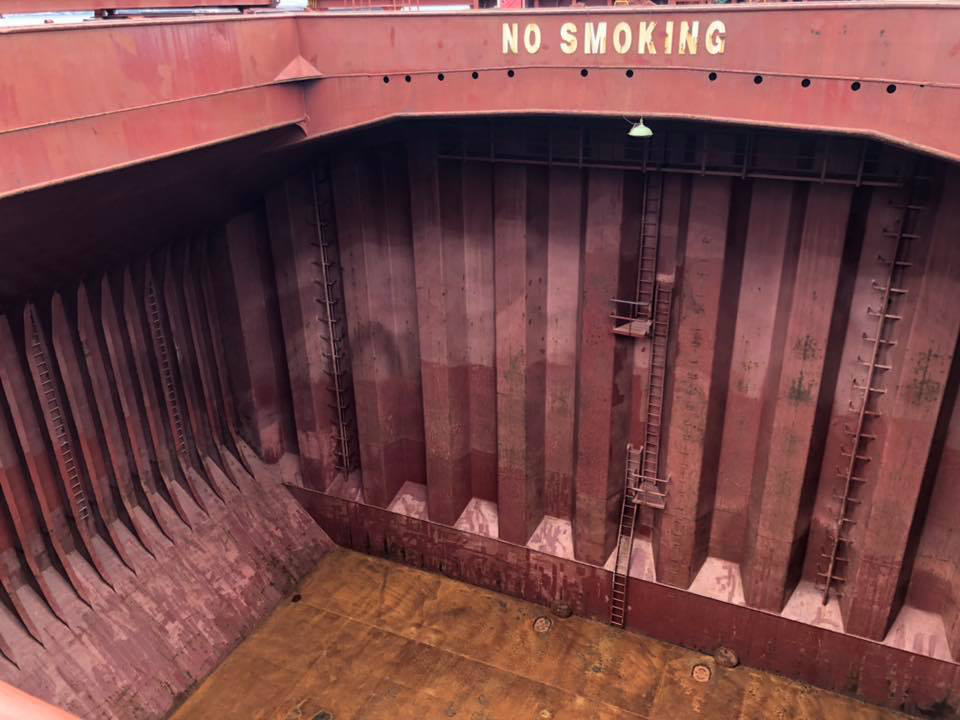

In [12]:
# Review dirty cargo hold image
dirty1 = load_img('../data/classified/dirty/46492613_1983209318392987_2701285471404687360_n.jpg')
dirty2 = load_img('../data/classified/dirty/46491446_1983209548392964_3471892652591415296_n.jpg')
dirty1

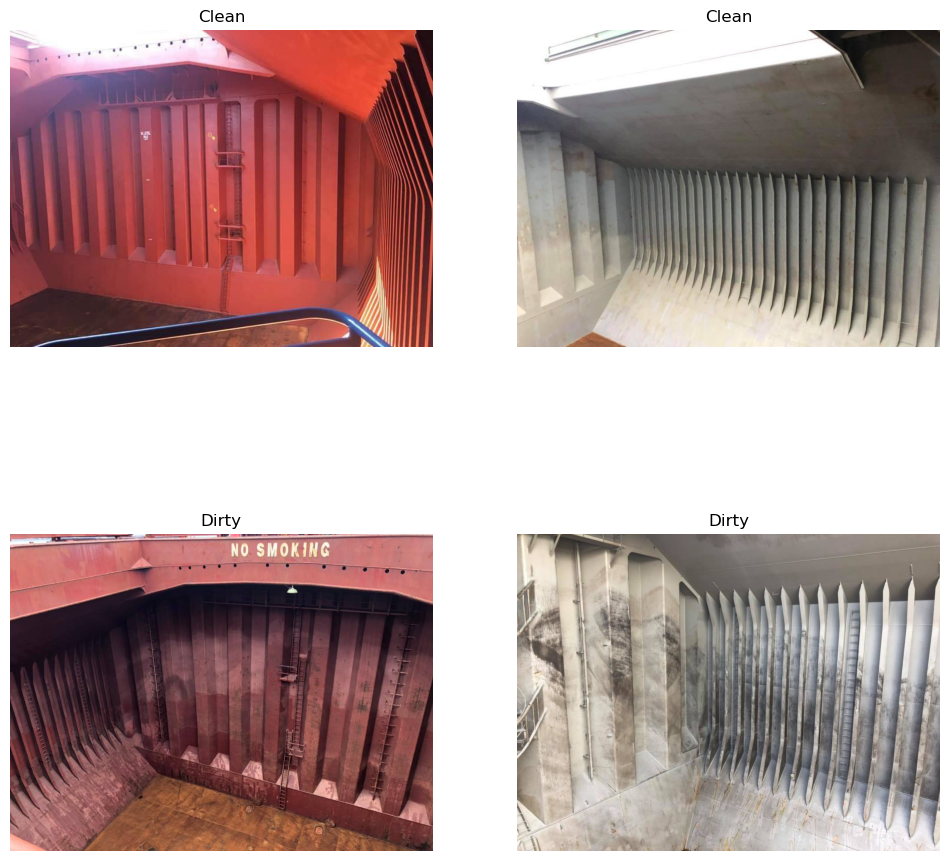

In [13]:
# Comparing clean to dirty with similar color hold coatings

fig, axes = plt.subplots(2, 2, figsize=(12,12))

axes[0, 0].imshow(clean1)
axes[0, 0].set_title('Clean')
axes[0, 0].axis('off')

axes[0, 1].imshow(clean2)
axes[0, 1].set_title('Clean')
axes[0, 1].axis('off')

axes[1, 0].imshow(dirty1)
axes[1, 0].set_title('Dirty')
axes[1, 0].axis('off')

axes[1, 1].imshow(dirty2)
axes[1, 1].set_title('Dirty')
axes[1, 1].axis('off')

plt.show;

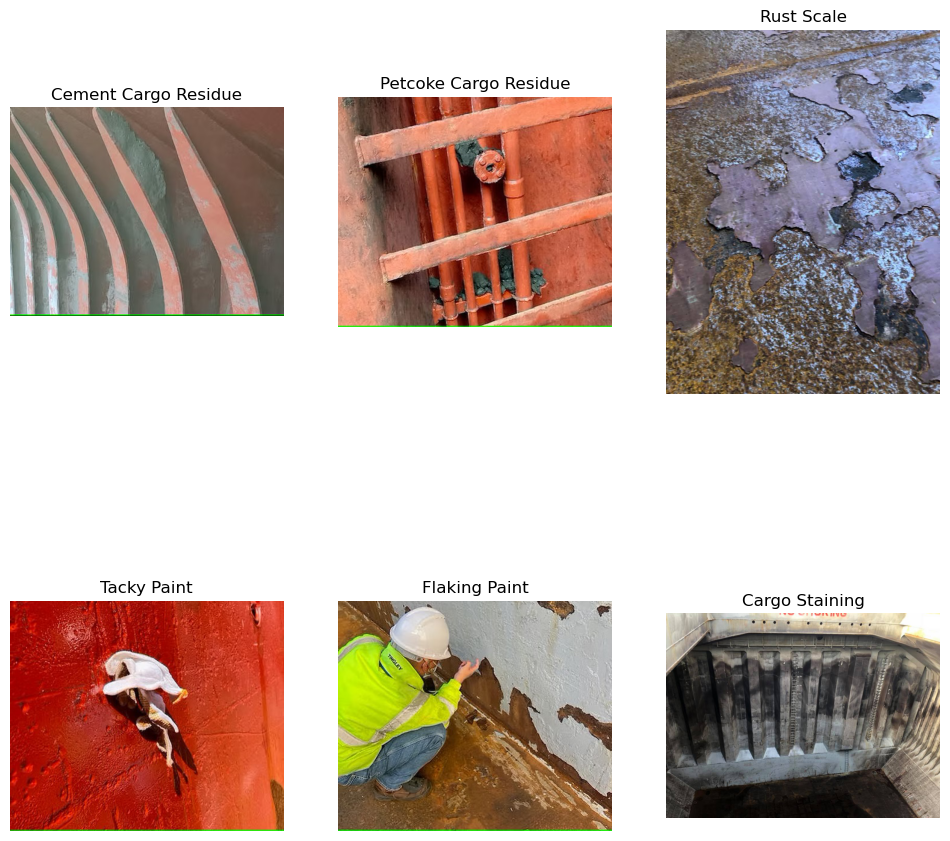

In [14]:
# different types of issues

cargoresidue = load_img('../data/classified/dirty/12c943_1ff40351da324d869a7f3b4c40d1b3e2~mv2.jpg')
cargoresidue2 = load_img('../data/classified/dirty/12c943_2fa04463d9254f2b8baf668e14de169a~mv2.jpg')
rustscale = load_img('../data/classified/dirty/66714988_2345934515453797_4846150941700784128_n.jpg')
tackypaint = load_img('../data/classified/dirty/12c943_e53efdefc0294acaa30e0a394f266436~mv2.jpg')
flakingpaint = load_img('../data/classified/dirty/12c943_efd8bd3332474e328fdbcef5cb7d2f46~mv2.jpg')
staining = load_img('../data/classified/dirty/46675044_1983208488393070_2248909549803143168_n.jpg')

fig, axes = plt.subplots(2, 3, figsize=(12,12))

axes[0, 0].imshow(cargoresidue)
axes[0, 0].set_title('Cement Cargo Residue')
axes[0, 0].axis('off')

axes[0, 1].imshow(cargoresidue2)
axes[0, 1].set_title('Petcoke Cargo Residue')
axes[0, 1].axis('off')

axes[0, 2].imshow(rustscale)
axes[0, 2].set_title('Rust Scale')
axes[0, 2].axis('off')

axes[1, 0].imshow(tackypaint)
axes[1, 0].set_title('Tacky Paint')
axes[1, 0].axis('off')

axes[1, 1].imshow(flakingpaint)
axes[1, 1].set_title('Flaking Paint')
axes[1, 1].axis('off')

axes[1, 2].imshow(staining)
axes[1, 2].set_title('Cargo Staining')
axes[1, 2].axis('off')

plt.show;

In [15]:
# gather image size ranges
clean_path = '../data/classified/clean/'
dirty_path = '../data/classified/dirty/'

clean_sizes = [load_img(os.path.join(clean_path, i)).size for i in os.listdir(clean_path)]
dirty_sizes = [load_img(os.path.join(dirty_path, i)).size for i in os.listdir(dirty_path)]

max(clean_sizes), min(clean_sizes), max(dirty_sizes), min(dirty_sizes)

((4032, 3024), (447, 382), (4032, 3024), (399, 336))

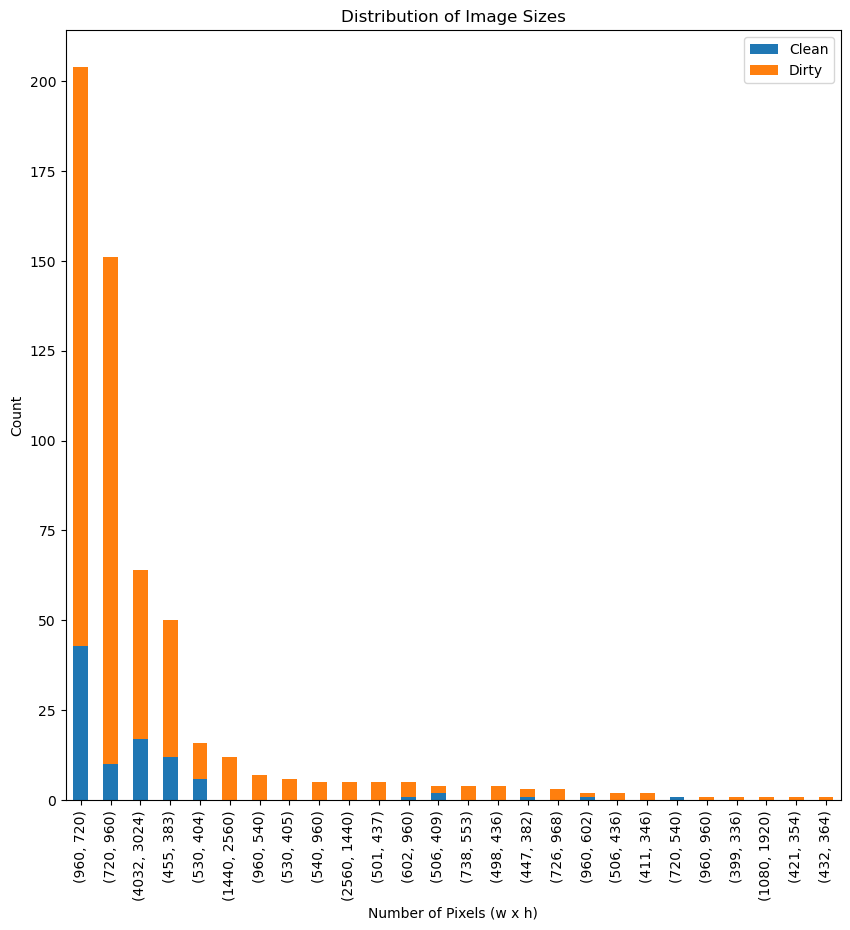

In [16]:
# Review image size distribution
clean_sizes_dist = pd.Series(clean_sizes).value_counts()
dirty_sizes_dist = pd.Series(dirty_sizes).value_counts() 

size_dist = pd.concat([clean_sizes_dist, dirty_sizes_dist], axis=1)
size_dist.columns = ['Clean', 'Dirty']
size_dist.fillna(0, inplace=True)
size_dist['Total'] = size_dist['Clean'] + size_dist['Dirty']
size_dist_sorted = size_dist.sort_values('Total', ascending=False)

# plotting distributions
ax = size_dist_sorted[['Clean', 'Dirty']].plot(figsize=(10,10), kind='bar', stacked=True)
ax.set_title('Distribution of Image Sizes')
ax.set_ylabel('Count')
ax.set_xlabel('Number of Pixels (w x h)')
plt.show();

___
#### Data Pre-processing

This project is working with an imbalanced and small dataset.  There are some preprocessing steps to take to improve the model performance.  These steps can be tailored in the future as the dataset size increases.

* Shuffling
* Image Augmentation
* Normalization
* Regularization
___



In [ ]:
# Holding 10 random images from each class to serve as a test set.

# get ten random clean images
random.shuffle(clean_images)
test_clean_list = clean_images[:10]

# make a filepath
test_clean = []
for image in test_clean_list:
    test_clean.append(clean_path+image)

# move to test directory
for clean_image in test_clean:
    shutil.move(clean_image, '../data/test/clean/')

# get ten random dirty images
random.shuffle(dirty_images)
test_dirty_list = dirty_images[:10]

# make a filepath
test_dirty = []
for image in test_dirty_list:
    test_dirty.append(dirty_path+image)

# move to test directory
for dirty_image in test_dirty:
    shutil.move(dirty_image, '../data/test/dirty/')

#### Image Augmentation
Synthetic images of the clean cargo hold class will be generated to address the class imbalance.  Oversampling the minority class could also work, but synthetic generation is preferred to avoid creating a bias by relying on multiple samples of the same image.  With synthetic creation, flips, crops, etc can create images that are not exactly identical in nature.

It should be noted that this approach is not ideal.  The size of this dataset is insufficient to provide confidence in the model's performance.  Only after obtaining more data (roughly 1000 images per class) should the model be considered for production.

In the real world, this dataset should be equally balanced. The vessel should provide pictures of dirty holds and eventually clean holds. A vessel's cargo holds are either dirty or clean.ved.
___


In [6]:
# generating more images from original dataset
balance_datagen = ImageDataGenerator(
    brightness_range=(0.5, 1.5),
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=[0.4, 0.6],
    channel_shift_range=100,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [9]:
def create_synthetics(image_list, target, destination_path):
    """Create more images from a given image list and save to destination"""
    # determine how many images to generate per image
    generate_per_image = target / (len(image_list))

    # loop through image list and generate synthetic images
    for image in image_list:
        try:
            x = load_img(image)
            x = img_to_array(x)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in balance_datagen.flow(x, batch_size=1, save_to_dir=destination_path, save_prefix='aug', save_format='jpg'):
                i += 1
                if i > generate_per_image:
                    break  
        except FileNotFoundError:
            print(f'{image} was not found as it was moved to the Test dataset. Skipping ...')
            continue

In [81]:
# Creating more clean images

#clean_class_images = [clean_path + file for file in clean_images]
#clean_augmented = '../data/augmented/'
#clean_target = 500
#create_synthetics(clean_class_images, clean_target, clean_augmented)

../data/classified/clean/12c943_68ff2f6250c24c1f9a712fa7b8d4b8ff~mv2.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/48172405_2008560542524531_4572915799617961984_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/IMG_9512.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/46502332_1983220911725161_1907524628331364352_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/98203756_2995577847156124_5441078696167342080_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/12c943_cd41237a10f2407b89f1966ac9b600f6~mv2.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/68916544_2395346270512621_1461372780061655040_n.jpg was not found as it was moved to the Test dataset. Skipping ...
../data/classified/clean/IMG_9513.jpg was not found as it wa

In [4]:
num_aug_clean = len([i for i in os.listdir('../data/augmented/clean/')])
num_aug_dirty = len([i for i in os.listdir('../data/augmented/dirty/')])
num_aug_clean, num_aug_dirty

(456, 456)

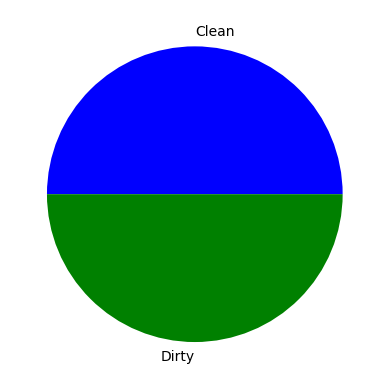

In [5]:
# Pie chart with class distribution
fig, ax = plt.subplots()
ax.pie(x=[num_aug_clean, num_aug_dirty], labels=['Clean', 'Dirty'], colors=['blue', 'green'])
plt.show;

In [55]:
# split the remaining images into training and validation datasets

# training & validation clean
try:
    augmented_clean_path = '../data/augmented/clean/'
    augmented_clean_images = [i for i in os.listdir(augmented_clean_path)]
    random.shuffle(augmented_clean_images)
    
    train_clean = []
    augmented_clean_train = augmented_clean_images[:410]
    for act_image in augmented_clean_train:
        train_clean.append(os.path.join(augmented_clean_path + act_image))
    for train_clean_image in train_clean:
        shutil.copy(train_clean_image, '../data/train/clean/')
        
    val_clean = []
    augmented_clean_val = augmented_clean_images[411:]
    for acv_image in augmented_clean_val:
        val_clean.append(os.path.join(augmented_clean_path + acv_image))
    for val_clean_image in val_clean:
        shutil.copy(val_clean_image, '../data/validate/clean/')
        
    #training & validation dirty
    augmented_dirty_path = '../data/augmented/dirty/'
    augmented_dirty_images = [i for i in os.listdir(augmented_dirty_path)]
    random.shuffle(augmented_dirty_images)
    
    train_dirty = []
    augmented_dirty_train = augmented_dirty_images[:410]
    for adt_image in augmented_dirty_train:
        train_dirty.append(os.path.join(augmented_dirty_path + adt_image))
    for train_dirty_image in train_dirty:
        shutil.copy(train_dirty_image, '../data/train/dirty/')
    
    val_dirty = []
    augmented_dirty_val = augmented_dirty_images[411:]
    for adv_image in augmented_dirty_val:
        val_dirty.append(os.path.join(augmented_dirty_path + adv_image))
    for val_dirty_image in val_dirty:
        shutil.copy(val_dirty_image, '../data/validate/dirty/')

except FileNotFoundError as e:
    print(f'Image was not found {e} as it was moved to the Test dataset. Skipping ...')

In [56]:
num_train_clean = len([i for i in os.listdir('../data/train/clean/')])
num_train_dirty = len([i for i in os.listdir('../data/train/dirty/')])

num_val_clean = len([i for i in os.listdir('../data/validate/clean/')])
num_val_dirty = len([i for i in os.listdir('../data/validate/dirty/')])

num_test_clean = len([i for i in os.listdir('../data/test/clean/')])
num_test_dirty = len([i for i in os.listdir('../data/test/dirty/')])

num_train_clean, num_train_dirty, num_val_clean, num_val_dirty, num_test_clean, num_test_dirty

(410, 410, 45, 45, 10, 10)

In [167]:
# create the image data generator to apply to the transformations to data
# the transformations are realistic as it relates to what could be seen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.5, 1.5),
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

validate_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [168]:
# Loading in image data
train_generator = train_datagen.flow_from_directory(
    '../data/train/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

validation_generator = validate_datagen.flow_from_directory(
    '../data/validate/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

Found 820 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [127]:
# add model checkpoints
from keras.callbacks import ModelCheckpoint
checkpoint_path='../assets/saved_models/'
ModelCheckpoint()

TypeError: ModelCheckpoint.__init__() missing 1 required positional argument: 'filepath'

In [169]:
# model for image classification
model = Sequential()
model.add(Input((224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

# compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='bce', metrics=['accuracy'])

model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 batch_normalization_96 (Bat  (None, 111, 111, 32)     128       
 chNormalization)                                                
                                                                 
 dropout_162 (Dropout)       (None, 111, 111, 32)      0         
                                                                 
 conv2d_126 (Conv2D)         (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 54, 54, 128)    

In [170]:
# fit model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
26/26 [==============================] - 41s 2s/step - loss: 6.7558 - accuracy: 0.5341 - val_loss: 6.1646 - val_accuracy: 0.5000
Epoch 2/10
26/26 [==============================] - 39s 2s/step - loss: 6.2510 - accuracy: 0.5671 - val_loss: 5.8504 - val_accuracy: 0.5000
Epoch 3/10
26/26 [==============================] - 40s 2s/step - loss: 5.8348 - accuracy: 0.6415 - val_loss: 5.6354 - val_accuracy: 0.5000
Epoch 4/10
26/26 [==============================] - 39s 1s/step - loss: 5.4900 - accuracy: 0.6402 - val_loss: 5.3412 - val_accuracy: 0.5000
Epoch 5/10
26/26 [==============================] - 39s 1s/step - loss: 5.2720 - accuracy: 0.5963 - val_loss: 4.8894 - val_accuracy: 0.5000
Epoch 6/10
26/26 [==============================] - 40s 2s/step - loss: 4.9962 - accuracy: 0.6073 - val_loss: 5.0699 - val_accuracy: 0.5000
Epoch 7/10
26/26 [==============================] - 40s 2s/step - loss: 4.6749 - accuracy: 0.6524 - val_loss: 5.2624 - val_accuracy: 0.5000
Epoch 8/10
26/26 [==

In [171]:
model.save('../assets/saved_models/second_best_model')

INFO:tensorflow:Assets written to: ../assets/saved_models/second_best_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/second_best_model\assets


#### Oversampling


In [4]:
clean_array =  img_to_array(clean)
clean_array.shape

(540, 720, 3)

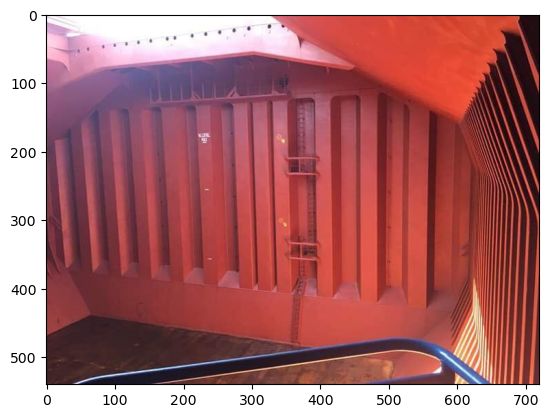

In [5]:
plt.imshow(clean_array/255)

#### Normalizaiotn

___

#### Train Validate Test

___

In [6]:
clean_array_reshaped = clean_array.reshape(clean_array.shape[0], -1)
clean_array_reshaped.shape

(540, 2160)

In [7]:
train, test = image_dataset_from_directory(
    '../data/cargo_holds/',
    image_size=(512, 512),
    batch_size=32,
    label_mode='binary',
    seed=27,
    validation_split=0.1,
    subset='both'
)

Found 120 files belonging to 2 classes.
Using 108 files for training.
Using 12 files for validation.


In [9]:
train.class_names, test.class_names

(['clean_website_reviewed', 'dirty_website_reviewed'],
 ['clean_website_reviewed', 'dirty_website_reviewed'])

To correct imbalance, can try oversampling minority


In [25]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

In [26]:
# make a pipeline to reandom over sample minority class
pipe = make_pipeline(RandomOverSampler(random_state=27))# model)
pipe

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=27))])

In [27]:
gs = GridSearchCV(pipe, {'randomoversampler__sampling_strategy': [.25, .5, .75, 1]}, n_jobs=-1)

In [28]:
gs.fit(train, test)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=27))]) does not.

#### Data Augmentation
___



In [ ]:
# data augmentation
datagen = ImageDataGenerator(
    brightness_range=(0.5, 1.5),
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.1,
    fill_mode='constant'
)

In [8]:
# Loading in image data
train_data, valid_data = image_dataset_from_directory(
    '../data/augmented/',
    image_size=(224, 224),
    batch_size=8,
    validation_split=0.1,
    subset='both',
    label_mode='binary',
    shuffle=True,
    seed=27,
)

Found 912 files belonging to 2 classes.
Using 821 files for training.
Using 91 files for validation.
